In [135]:
import pandas as pd

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test_features.csv')

In [136]:
train_df.head()

,ID,Text,Category
0,969,@JuliaBradbury @SimonCalder @walsop @HodderPRI...,0
1,241,or here https://t.co/R2tO79Easn … .An in house...,1
2,820,@britshmuseum @thehistoryguy Gosh periscope is...,2
3,693,@Ophiolatrist britishmuseum The stupid #French...,1
4,421,@SassyClde We won't stop til @britishmuseum du...,1


In [137]:
train_df = train_df.drop(columns=['ID'])
train_df.head()

,Text,Category
0,@JuliaBradbury @SimonCalder @walsop @HodderPRI...,0
1,or here https://t.co/R2tO79Easn … .An in house...,1
2,@britshmuseum @thehistoryguy Gosh periscope is...,2
3,@Ophiolatrist britishmuseum The stupid #French...,1
4,@SassyClde We won't stop til @britishmuseum du...,1


In [138]:
train_df.isna().sum()

Text        0
Category    0
dtype: int64

### Tokenizer

In [139]:
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize

try:
    nltk.data.find('tokenizers/punkt')
except:
    raise Exception('nltk.data not found')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/amaury-
[nltk_data]    |     delille/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /home/amaury-
[nltk_data]    |     delille/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/amaury-delille/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/amaury-delille/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/amaury-delille/nltk_data...
[nltk_data]    |   Package averaged_perceptron_ta

Word occurences

{'@': 2762,
 'the': 870,
 '#': 830,
 ':': 794,
 '.': 703,
 'britishmuseum': 628,
 'to': 515,
 '!': 485,
 'nationalgallery': 485,
 'http': 475,
 ',': 448,
 '?': 424,
 'a': 415,
 'of': 358,
 'i': 316,
 'in': 296,
 'and': 248,
 'on': 245,
 ';': 244,
 'it': 234,
 'is': 218,
 'at': 217,
 'you': 213,
 'that': 198,
 'for': 185,
...
 'platformlondon': 3,
 'couple': 3,
 'favourites': 3,
 'another': 3,
 ...}

In [140]:

import re
from nltk.stem import WordNetLemmatizer
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# I don't use nltk stopwords set bc it will remove words such as "not", "don't", etc..,
# which are necessary to sentiment analyis. 

train_df = train_df.rename(columns={feature: feature.lower() for feature in train_df.columns})
test_df = test_df.rename(columns={feature: feature.lower() for feature in test_df.columns})

stopwords = ['@', '#', ':', 'the', '?', 'to', ';', ',', '.', 'on', 'that', 'for', 'a', "'", '-', '&', 'http', '...']
lemmatizer = WordNetLemmatizer()

def check_regex(word: str):
    # match links and numbers independently
    is_link = re.search(r"http(s)?://|www\.\S+|//\S+", word) 
    has_number = re.search(r"\d", word)
    return is_link or has_number

def process_word(word: str):
    return lemmatizer.lemmatize(word.lower())

def update_length(base_length: int, n: int):
    return max(base_length, n)

def preprocess(df: pd.DataFrame):
    x = []
    base_length = 0

    for text in df['text']:
        text = str(text)
        words = word_tokenize(text)
        processed_words = [process_word(word) for word in words if word.lower() not in stopwords and not check_regex(word)]

        # necessary to pad every processed list, it updates the base length of each list.
        base_length = update_length(base_length=base_length, n=len(processed_words))
        x.append(processed_words)
    
    return x, base_length
        
x, x_length = preprocess(train_df)
test, test_length = preprocess(test_df)

base_length = max(test_length, x_length)
vocab_size = 1000

tokenizer = Tokenizer(num_words=vocab_size)

# create the vocabulary.
tokenizer.fit_on_texts(x)
tokenizer.fit_on_texts(test)

# encode into integers.
training_sequences = tokenizer.texts_to_sequences(x)
testing_sequences = tokenizer.texts_to_sequences(test)

# truncating is not really necessary since we use the max length as our base length.
training_padded = pad_sequences(training_sequences, maxlen=base_length, padding='post', truncating='pre')
testing_padded = pad_sequences(testing_sequences, maxlen=base_length, padding='post', truncating='pre')

training_padded.shape[1] == testing_padded.shape[1]

True

In [141]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras import layers, Sequential


columns = [f'word_{i}' for i in range(base_length)]
X = pd.DataFrame(data=training_padded, columns=columns)
y = train_df['category']
num_classes = y.nunique()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    # converts integers sequence into a dense vector of size embedding_dim.
    layers.Embedding(vocab_size, input_length=base_length, output_dim=32),
    # reduces the sequence of embeddings into a single vector by averaging values across all words.
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

epochs = 50

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=epochs,
    batch_size=32
)

Epoch 1/50


/home/amaury-delille/.local/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2880 - loss: 1.3798 - val_accuracy: 0.3187 - val_loss: 1.3467
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4897 - loss: 1.3248 - val_accuracy: 0.7500 - val_loss: 1.2483
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7802 - loss: 1.1974 - val_accuracy: 0.8719 - val_loss: 1.0696
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8415 - loss: 0.9852 - val_accuracy: 0.8844 - val_loss: 0.8303
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8979 - loss: 0.7266 - val_accuracy: 0.8875 - val_loss: 0.6217
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9020 - loss: 0.5420 - val_accuracy: 0.8938 - val_loss: 0.4750
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9332 - loss: 0.3887 - val_accuracy: 0.9031 - val_loss: 0.3717
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.9363 - loss: 0.2833 - val_accuracy: 0.9438 - val_loss: 0.2975
E

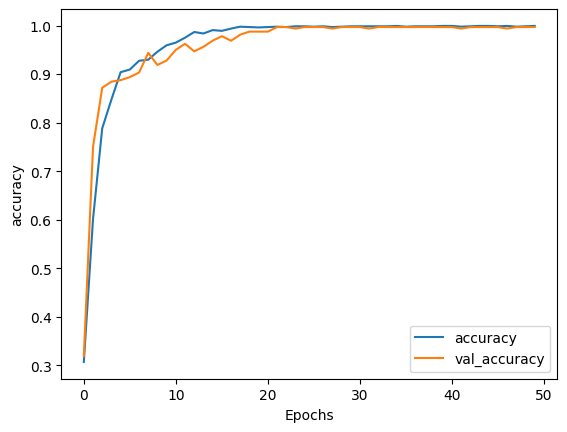

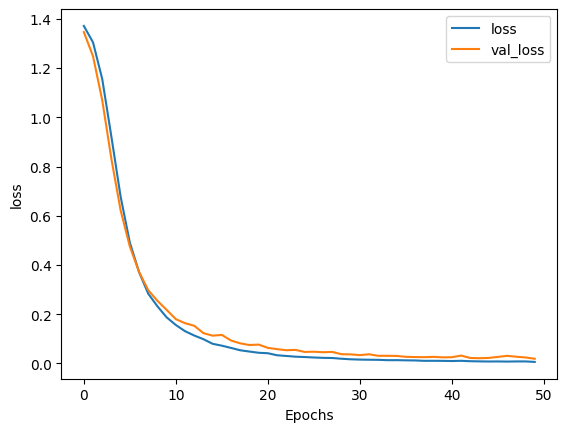

In [142]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [144]:
testing = pd.DataFrame(data=testing_padded, columns=columns)

predictions = model.predict(testing_padded)
sentiments = ['Positive/Excitement', 'Criticism/Concern', 'Neutral/Informative', 'Confusion/Request for Info']

submission_predictions = []

for index, prediction in enumerate(predictions):
    predicted = np.argmax(prediction)
    submission_predictions.append(predicted)
    emotion = sentiments[predicted]
    text = test_df['text'].loc[index]
    print(f'Predicted: {emotion}, Text: {text}')

submission_df = pd.DataFrame({
    'ID': test_df['id'],
    'Prediction': submission_predictions
})

submission_df.to_csv('submission.csv', index=False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
Predicted: Confusion/Request for Info, Text: Goodbye @kettlesyard see you in .25 years! http://t.co/WFjBAiWbfM
Predicted: Confusion/Request for Info, Text: @BBC_Culture @PlymouthMuseum Oh dear, why not Dame Laura Knight? Surely 'The Beach' should be in this lst!
Predicted: Criticism/Concern, Text: Fantastic @johnmcdonnellMP standing up for workers @NationalGallery #noprivatisatio while @edvaizey sits on fence! http://t.co/QzBYpUAtQt
Predicted: Confusion/Request for Info, Text: @BBC_Culture @PlymouthMuseum Oh dear, why not Dame Laura Knight? Surely'The Beach' should be in this list!
Predicted: Neutral/Informative, Text: @britishmuseum @TripAdvisor it is !
Predicted: Confusion/Request for Info, Text: @britishmuseum @thehistoryguy shame about the idiots who post rude cmments throughout!
Predicted: Neutral/Informative, Text: Lots of ancient artefacts to enjoy @britishmuseum #amazingplace #toomuchforaquickvisit http://t.co/utnDOEiGXO
Predicted: Posit